    14/11/17
- fix alignment algorithm (stopped working properly after fast vs slow detection fixed)
- better to phase sync on first note/ closer to transition point (not so important)
- light signal filter parameters and nwind parameter need to be tweaked depending on modulation frequency
- need to model pulse with exp decay as hypothesis for fast transition observed increase in amplitude (pulse produced by air pushed inwards due to the key closure --- see water hammer model)
- initial tests of the above model completed by observing the pressure mic waveform without any air flow (DC flow)
- need automated way to extract period information (by single periods) within transition time
- test hypothesis that not-very-open state causes the most loss, and therefore the opening transitions show sharp decreases in amplitude (most time spent in NVO) where closing transitions do not (least time spent in NVO, most in NVC) 
    - see http://newt.phys.unsw.edu.au/jw/reprints/AlmeidaetalJASA09.pdf#c10

### General Observations
- Beating effect in external channel for some transitions, f = 62Hz
- Some slower oscillations in internal channel at 2.5Hz in F\#4 note --- see 4750rpm rec 2
- Transition type 1 from D4 to F\#4 --- fundamental freqs. D4 = ca. 300Hz, F\#4 = ca. 376Hz (not much change for rpm range)
- Transition to second note (new freq) happens within 1 or 2 cycles at small key openings
- Pulses on some faster transitions, amplitude rises and then decays back exponentially, possibly due to key-injected pulse
- Key opening transitions more consistent, always display >50% loss of power at small key openings

In [1]:
import audacity as au
import numpy as np
import scipy.io.wavfile as wf
import scipy.signal as sig
import matplotlib.pyplot as pl
%matplotlib notebook

In [2]:
rpm = 4500
rec = 2
auf = au.Aup('%drpm/flute_hybrid_rec%d.aup' %(rpm, rec))
w=[]
sr = auf.rate
for chno in range(auf.nchannels):
    w.append(auf.get_channel_data(chno))
w1=w[0]
w2=w[1]
w3=w[2]
#sr, w1 = wf.read('%drpm/flute_hybrid_rec1-01.wav' %rpm)
#sr, w2 = wf.read('%drpm/flute_hybrid_rec1-02.wav' %rpm)
#sr, w3 = wf.read('%drpm/flute_hybrid_rec1-03.wav' %rpm)

In [3]:
def RMSWind(x, sr=1, nwind=1024, nhop=512, windfunc=np.blackman):
    '''
    Calculates the RMS amplitude amplitude of x, in frames of
    length nwind, and in steps of nhop. windfunc is used as
    windowing function.
    nwind should be at least 3 periods if the signal is periodic.
    '''

    nsam = len(x)
    ist = 0
    iend = ist+nwind

    t = []
    ret = []

    wind = windfunc(nwind)
    wsum2 = np.sum(wind**2)

    while (iend < nsam):
        thisx = x[ist:iend]
        xw = thisx*wind

        ret.append(np.sum(xw*xw/wsum2))
        t.append(float(ist+iend)/2.0/float(sr))

        ist = ist+nhop
        iend = ist+nwind

    return np.sqrt(np.array(ret)), np.array(t)

In [4]:
b, a = sig.butter(4, 1000/sr, 'high')
keysignal = sig.filtfilt(b,a,w3, padtype='constant')

rms, t=RMSWind(keysignal,sr=sr,nwind=16,nhop=20)

<IPython.core.display.Javascript object>


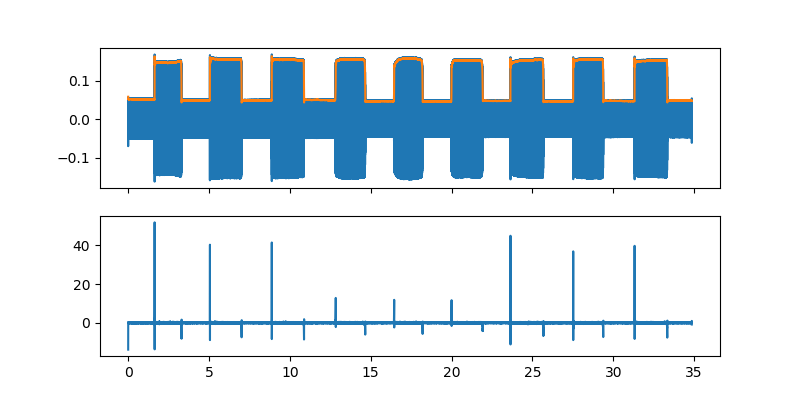

9

In [5]:
fig,ax = pl.subplots(2,sharex=True,figsize=(8,4))

ax[0].plot(np.arange(len(keysignal))/sr, keysignal)
ax[0].plot(t, rms*np.sqrt(2))
maxargs = sig.argrelmax(keysignal, order=10)[0]
maxvals = [ keysignal[arg] for arg in maxargs ]
# ax[0].plot(maxargs/sr, maxvals)

delx = np.gradient(rms*np.sqrt(2))
delt = np.gradient(t)
v_test = delx/delt

g, h = sig.butter(2, 10/sr)
v_filt = sig.filtfilt(g,h,v_test, padtype='constant')

v_maxat = sig.argrelmax(v_filt, order=50)[0]

ax[1].plot(t, v_test)
# ax[1].scatter((v_maxat*len(keysignal)/len(t))/sr, np.zeros(len(v_maxat)), c='r', marker='.')
# ax[1].plot(t, v_filt)
len(v_maxat)

In [9]:
def keysync(audio, keyRMS, t, sr, opt):
    
    keyfast = []
    keyslow = []
    keyopen = []
    
    fast = []
    slow = []
    opening = []
    
    keysig = keyRMS*np.sqrt(2)
    
    del_x = np.gradient(keysig)
    del_t = np.gradient(t)
    v = del_x/del_t
    
    b, a = sig.butter(2, 10/sr)
    vfilt = sig.filtfilt(b, a, v, padtype='constant')
    
    mx = sig.argrelmax(vfilt, order=1)[0]
    mn = sig.argrelmin(vfilt, order=1)[0]
    
    t_mx = mx*((len(audio)/len(t))/sr)
    t_mn = mn*((len(audio)/len(t))/sr)
    
    max_at = [ mx[k] for k in range(len(mx)) if t[-2206] > t_mx[k] > 1. ]
    min_at = [ mn[l] for l in range(len(mn)) if t[-2206] > t_mn[l] > 1. ]
    
    vmax = [ np.amax(v[m-int(0.1*2206):m+int(0.1*2206)]) for m in max_at ]
       
    for i in range(len(max_at)):
        if vmax[i] < 15:
            slow.append(audio[int(np.around(t_mx[i]*sr))-int(0.1*sr):int(np.around(t_mx[i]*sr))+int(0.4*sr)])
            keyslow.append(keysig[max_at[i]-int(0.1*2206):max_at[i]+int(0.4*2206)])
        if vmax[i] > 15:
            fast.append(audio[int(np.around(t_mx[i]*sr))-int(0.1*sr):int(np.around(t_mx[i]*sr))+int(0.4*sr)])
            keyfast.append(keysig[max_at[i]-int(0.1*2206):max_at[i]+int(0.4*2206)])
        
    for j in range(len(min_at)):
        opening.append(audio[int(t_mn[j]*sr)-int(0.25*sr):int(t_mn[j]*sr)+int(0.25*sr)])
        keyopen.append(keysig[min_at[j]-int(0.25*2206):min_at[j]+int(0.25*2206)])
    
    if opt=='audio':
        F = fast
        S = slow
        O = opening
        return F, S, O
    if opt=='key':
        F = keyfast
        S = keyslow
        O = keyopen
        return F, S, O

In [10]:
clips = keysync(w2, rms, t, sr, 'audio')
motion = keysync(w2, rms, t, sr, 'key')

# a_close = clips[0]
# a_open = clips[1]
# k_close = motion[0]
# k_open = motion[1]
a_fast = clips[0]
a_slow = clips[1]
a_open = clips[2]
k_fast = motion[0]
k_slow = motion[1]
k_open = motion[2]


# # ax[1].specgram(open1, Fs=sr/len(w2))
# # ax[1].specgram(open2)
# len(k_open), len(k_close)
len(a_fast), len(a_slow)

(5, 4)

In [11]:
# def phasesync(audioclips, keysigs, sr):
#     a_times = []
#     k_times = []
    
#     for i in range(len(audioclips)):
#         clip = audioclips[i]
#         keyclip = keysigs[i]
#         reverse = clip[::-1]
#         last_min = (sig.argrelmin(reverse)[0][0])/sr
# #         last_max = (sig.argrelmax(reverse)[0][0])/sr
#         a_times.append([np.arange(len(clip))/sr + last_min])
#         k_times.append([np.arange(len(keyclip))*(1/2206) + last_min])
        
#     return a_times, k_times

# t_fast = phasesync(a_fast, k_fast, sr)
# t_slow = phasesync(a_slow, k_slow, sr)
# t_open = phasesync(a_open, k_open, sr)

<IPython.core.display.Javascript object>


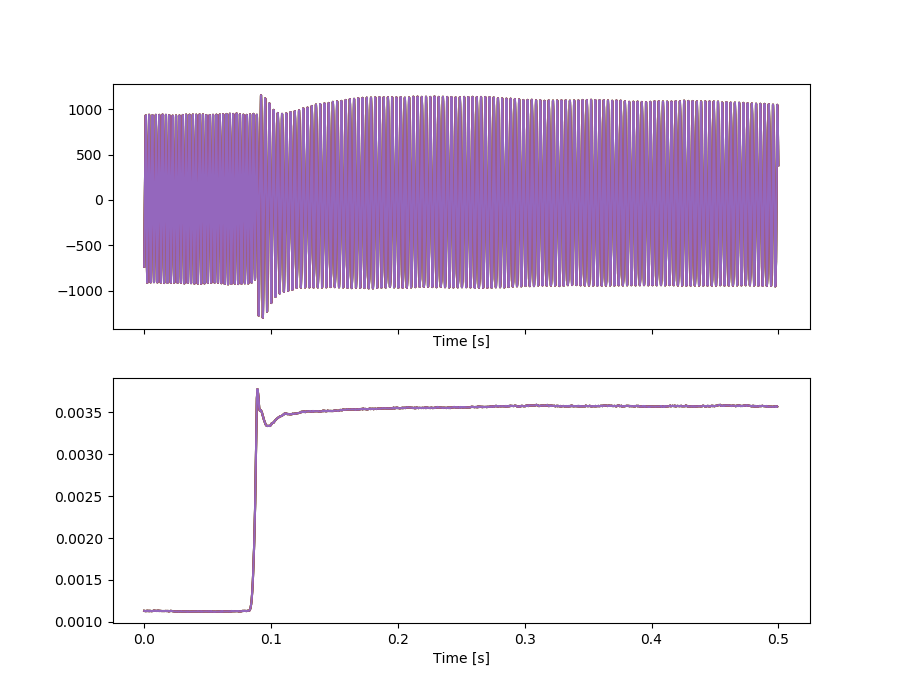

In [24]:
fig,ax = pl.subplots(2, sharex=True, figsize=(9,7))
fig.set_label('Fast transitions')

t_units = 1/2206
for i in range(len(k_fast)):
#     ax[0].plot(t_fast[0][i][0], a_fast[i])
    ax[0].set_xlabel('Time [s]')
#     ax[1].plot(t_fast[1][i][0], k_fast[i])
    ax[1].set_xlabel('Time [s]')
    ax[0].plot(np.arange(len(a_fast[1]))/sr, a_fast[1]/0.000013967527449131013)
    ax[1].plot(np.arange(len(k_fast[1]))*t_units, k_fast[1]*0.023091481474031384)

<IPython.core.display.Javascript object>


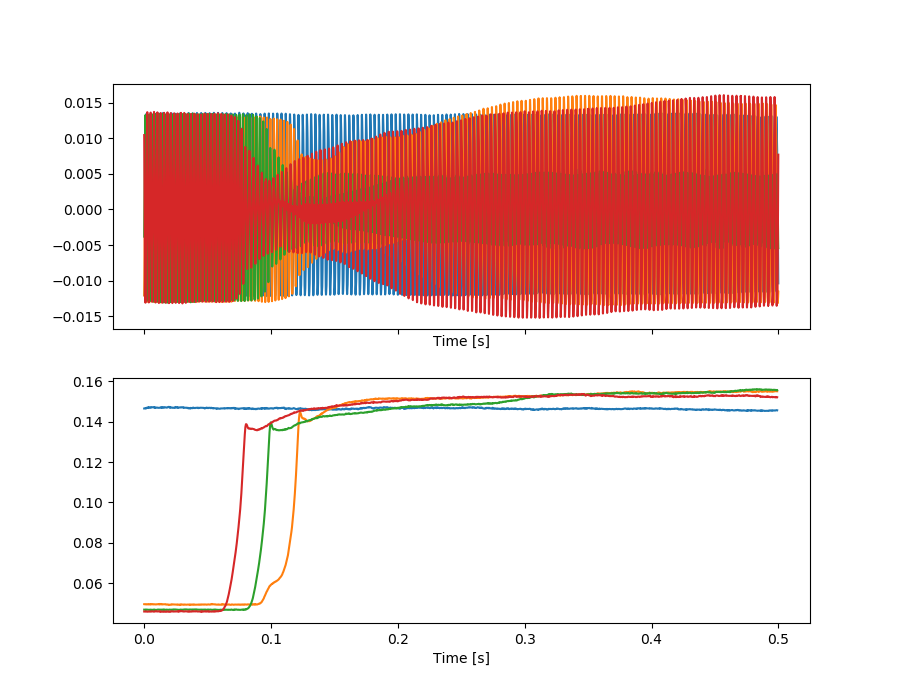

In [14]:
fig,ax = pl.subplots(2, sharex=True, figsize=(9,7))
fig.set_label('Slow transitions')

t_units = 1/2206
for i in range(len(k_slow)):
#     ax[0].plot(t_slow[0][i][0], a_slow[i])
    ax[0].plot(np.arange(len(a_slow[i]))/sr, a_slow[i])
    ax[0].set_xlabel('Time [s]')
#     ax[1].plot(t_slow[1][i][0], k_slow[i])
    ax[1].plot(np.arange(len(k_slow[i]))*t_units, k_slow[i])
    ax[1].set_xlabel('Time [s]')

<IPython.core.display.Javascript object>


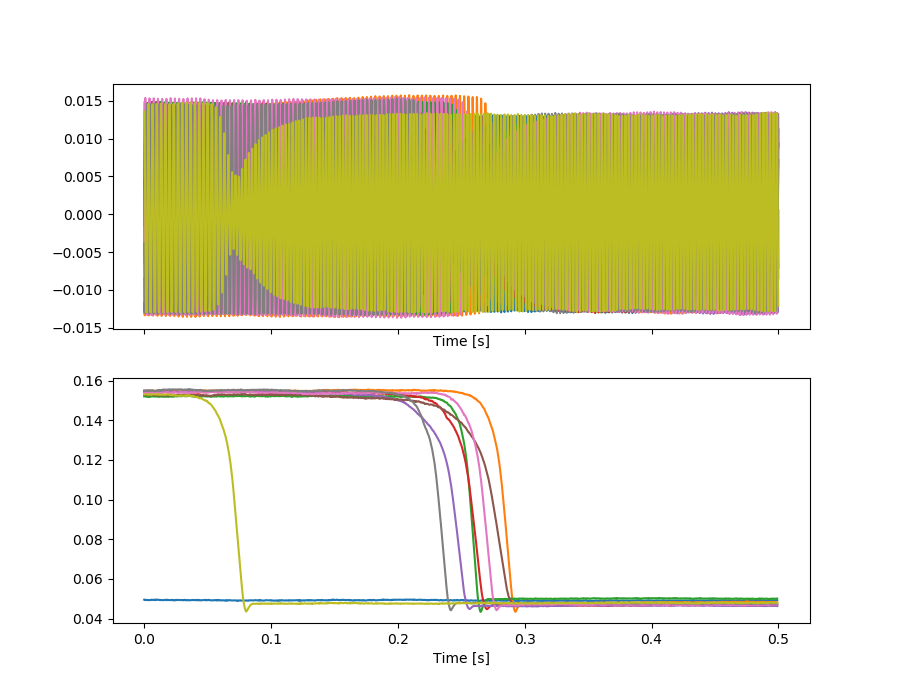

In [15]:
fig,ax = pl.subplots(2, sharex=True, figsize=(9,7))
fig.set_label('Opening transitions')

t_units = 1/2206
for j in range(len(k_open)):
#     ax[0].plot(t_open[0][j][0], a_open[j])
    ax[0].set_xlabel('Time [s]')
#     ax[1].plot(t_open[1][j][0], k_open[j])
    ax[1].set_xlabel('Time [s]')
    ax[0].plot(np.arange(len(a_open[j]))/sr, a_open[j])
    ax[1].plot(np.arange(len(k_open[j]))*t_units, k_open[j])

In [11]:
# sig.filtfilt?

In [12]:
#pl.axes(ax[1])
#pl.specgram(w2,Fs=sr,NFFT=512)

In [13]:
# t[-1], t[-2206], 1/2206,